# Hệ thống gợi ý phim với TMDB 5000

**Môn**: Final Project - Recommendation System  
**Mô tả**: Xây dựng hệ thống gợi ý phim (movie recommender) dựa trên dữ liệu TMDB 5000 (`tmdb_5000_movies.csv`, `tmdb_5000_credits.csv`).

Các phần chính:
1. Thu thập & nạp dữ liệu
2. Làm sạch & chuẩn bị dữ liệu
3. Phân tích & trực quan hóa dữ liệu
4. Xây dựng hệ gợi ý (content-based)
5. Đánh giá mô hình (RMSE, MAE, Precision@K, Recall@K)
6. Giao diện gợi ý trong notebook (nhập tên phim để nhận gợi ý)



In [21]:
# Cài đặt và import thư viện

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

pd.set_option('display.max_colwidth', 200)

# Sử dụng style an toàn cho mọi phiên bản matplotlib
try:
    plt.style.use('seaborn-v0_8')
except:
    plt.style.use('seaborn-darkgrid')  # Fallback cho phiên bản cũ

print("Thư viện đã được import.")


Thư viện đã được import.


In [22]:
# 1. Thu thập & nạp dữ liệu

movies_path = 'tmdb_5000_movies.csv'
credits_path = 'tmdb_5000_credits.csv'

movies = pd.read_csv(movies_path)
credits = pd.read_csv(credits_path)

print('Kích thước movies:', movies.shape)
print('Kích thước credits:', credits.shape)

movies.head(3)


Kích thước movies: (4803, 20)
Kích thước credits: (4803, 4)


,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""name"": ""Fantasy""}, {""id"": 878, ""name"": ""Science Fiction""}]",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"": 2964, ""name"": ""future""}, {""id"": 3386, ""name"": ""space war""}, {""id"": 3388, ""name"": ""space colony""}, {""id"": 3679, ""name"": ""society""}, {""id"": 3801, ""name...",en,Avatar,"In the 22nd century, a paraplegic Marine is dispatched to the moon Pandora on a unique mission, but becomes torn between following orders and protecting an alien civilization.",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289}, {""name"": ""Twentieth Century Fox Film Corporation"", ""id"": 306}, {""name"": ""Dune Entertainment"", ""id"": 444}, {""name"": ""Lightstorm Entertainment"", ""id""...","[{""iso_3166_1"": ""US"", ""name"": ""United States of America""}, {""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""}]",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso_639_1"": ""es"", ""name"": ""Espa\u00f1ol""}]",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""name"": ""Fantasy""}, {""id"": 28, ""name"": ""Action""}]",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""name"": ""drug abuse""}, {""id"": 911, ""name"": ""exotic island""}, {""id"": 1319, ""name"": ""east india trading company""}, {""id"": 2038, ""name"": ""love of one's life...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, has come back to life and is headed to the edge of the Earth with Will Turner and Elizabeth Swann. But nothing is quite as it seems.",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""name"": ""Jerry Bruckheimer Films"", ""id"": 130}, {""name"": ""Second Mate Productions"", ""id"": 19936}]","[{""iso_3166_1"": ""US"", ""name"": ""United States of America""}]",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""name"": ""Adventure""}, {""id"": 80, ""name"": ""Crime""}]",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name"": ""based on novel""}, {""id"": 4289, ""name"": ""secret agent""}, {""id"": 9663, ""name"": ""sequel""}, {""id"": 14555, ""name"": ""mi6""}, {""id"": 156095, ""name"": ""brit...",en,Spectre,"A cryptic message from Bond’s past sends him on a trail to uncover a sinister organization. While M battles political forces to keep the secret service alive, Bond peels back the layers of deceit ...",107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""name"": ""Danjaq"", ""id"": 10761}, {""name"": ""B24"", ""id"": 69434}]","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""}, {""iso_3166_1"": ""US"", ""name"": ""United States of America""}]",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""}, {""iso_639_1"": ""en"", ""name"": ""English""}, {""iso_639_1"": ""es"", ""name"": ""Espa\u00f1ol""}, {""iso_639_1"": ""it"", ""name"": ""Italiano""}, {""iso_639_1"": ""de"", ""na...",Released,A Plan No One Escapes,Spectre,6.3,4466


In [23]:
# 2. Làm sạch & chuẩn bị dữ liệu

# Gộp thông tin credits vào movies theo movie_id
credits_renamed = credits.rename(columns={'movie_id': 'id'})
movies_merged = movies.merge(credits_renamed[['id', 'cast', 'crew']], on='id', how='left')

print('Kích thước sau khi merge:', movies_merged.shape)

# Loại bỏ duplicate theo title
before_dups = movies_merged.shape[0]
movies_merged = movies_merged.drop_duplicates(subset=['title'])
after_dups = movies_merged.shape[0]
print(f'Drop duplicate theo title: {before_dups} -> {after_dups}')

# Xử lý missing values cho text: thay bằng chuỗi rỗng
text_cols = ['overview', 'tagline', 'cast', 'crew', 'keywords', 'genres']
for col in text_cols:
    if col in movies_merged.columns:
        movies_merged[col] = movies_merged[col].fillna('')

# Xử lý missing cho numeric: thay bằng median
num_cols = ['vote_average', 'vote_count', 'popularity', 'runtime']
for col in num_cols:
    if col in movies_merged.columns:
        movies_merged[col] = movies_merged[col].fillna(movies_merged[col].median())

# Xử lý outlier đơn giản: clip vote_count ở percentiles 1% - 99%
low, high = movies_merged['vote_count'].quantile([0.01, 0.99])
movies_merged['vote_count_clipped'] = movies_merged['vote_count'].clip(lower=low, upper=high)

# Chuẩn hóa một số đặc trưng numeric
scaler = MinMaxScaler()
movies_merged[['vote_avg_scaled', 'popularity_scaled', 'vote_count_scaled']] = scaler.fit_transform(
    movies_merged[['vote_average', 'popularity', 'vote_count_clipped']]
)

movies_merged[['title', 'vote_average', 'vote_avg_scaled']].head(3)


Kích thước sau khi merge: (4803, 22)
Drop duplicate theo title: 4803 -> 4800


,title,vote_average,vote_avg_scaled
0,Avatar,7.2,0.72
1,Pirates of the Caribbean: At World's End,6.9,0.69
2,Spectre,6.3,0.63


## 3. Phân tích & Trực quan hóa dữ liệu


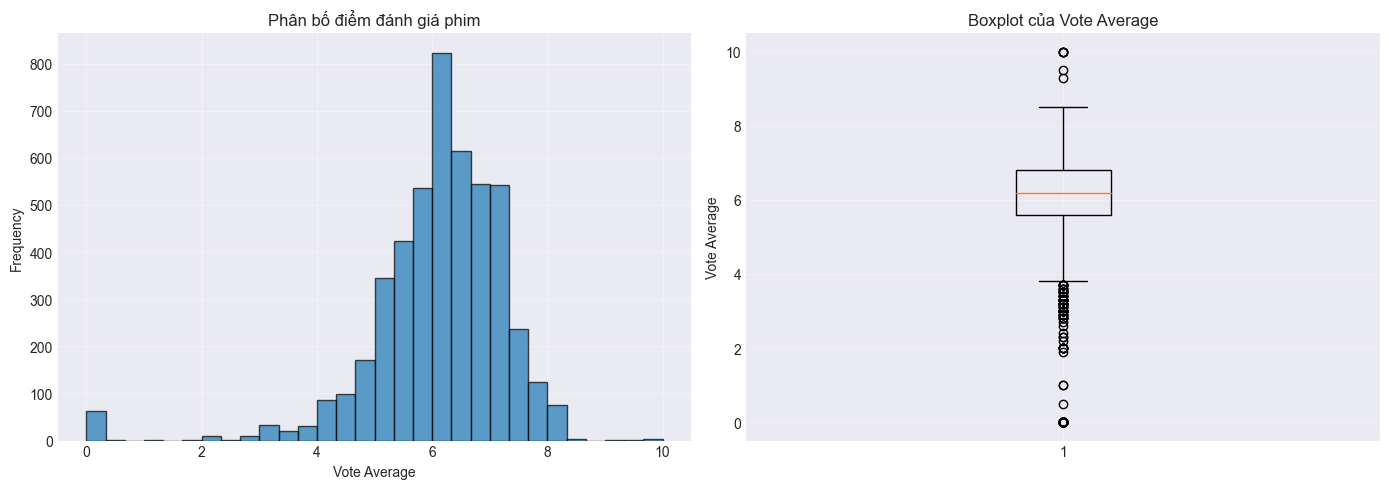

Mean vote: 6.09
Median vote: 6.20
Std vote: 1.19


In [24]:
### 3.1. Phân bố Rating (vote_average)

fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
ax[0].hist(movies_merged['vote_average'], bins=30, edgecolor='black', alpha=0.7)
ax[0].set_xlabel('Vote Average')
ax[0].set_ylabel('Frequency')
ax[0].set_title('Phân bố điểm đánh giá phim')
ax[0].grid(alpha=0.3)

# Boxplot
ax[1].boxplot(movies_merged['vote_average'], vert=True)
ax[1].set_ylabel('Vote Average')
ax[1].set_title('Boxplot của Vote Average')
ax[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Mean vote: {movies_merged['vote_average'].mean():.2f}")
print(f"Median vote: {movies_merged['vote_average'].median():.2f}")
print(f"Std vote: {movies_merged['vote_average'].std():.2f}")


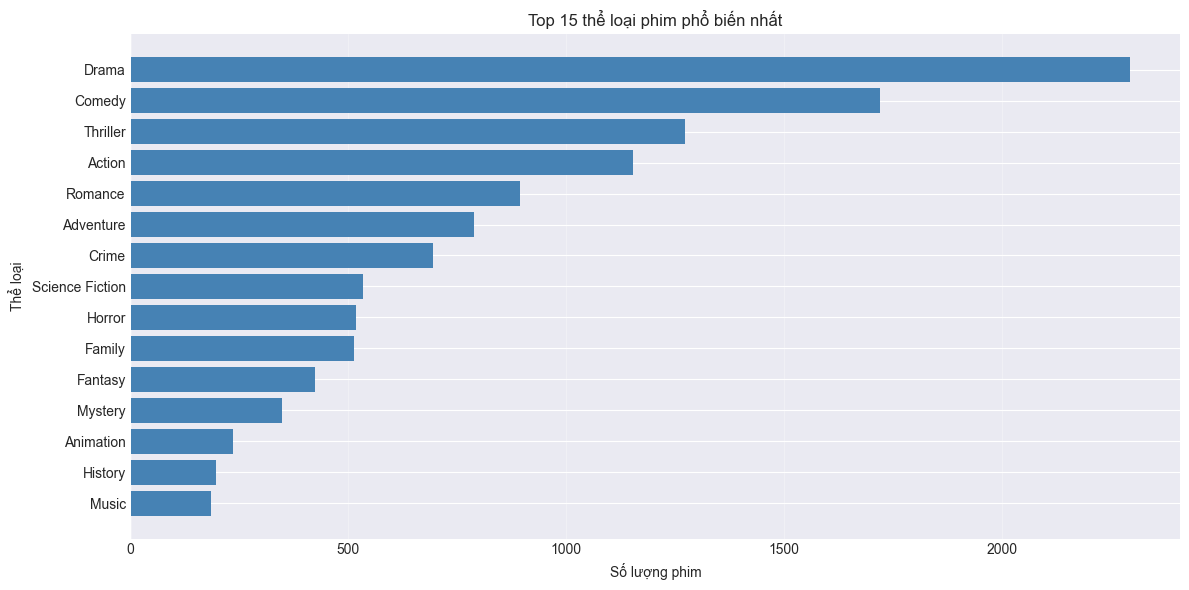

Tổng số thể loại khác nhau: 20


In [25]:
### 3.2. Tần suất thể loại phim (Genres)

import json
from collections import Counter

# Parse genres từ JSON string
def extract_genres(genres_str):
    try:
        genres_list = json.loads(genres_str)
        return [g['name'] for g in genres_list]
    except:
        return []

movies_merged['genres_list'] = movies_merged['genres'].apply(extract_genres)

# Đếm tần suất
all_genres = []
for genres in movies_merged['genres_list']:
    all_genres.extend(genres)

genre_counts = Counter(all_genres)
top_genres = genre_counts.most_common(15)

# Vẽ bar chart
genres_df = pd.DataFrame(top_genres, columns=['Genre', 'Count'])
plt.figure(figsize=(12, 6))
plt.barh(genres_df['Genre'], genres_df['Count'], color='steelblue')
plt.xlabel('Số lượng phim')
plt.ylabel('Thể loại')
plt.title('Top 15 thể loại phim phổ biến nhất')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Tổng số thể loại khác nhau: {len(genre_counts)}")


In [26]:
### 3.3. Top 10 phim có rating cao nhất

top_rated = movies_merged.nlargest(10, 'vote_average')[['title', 'vote_average', 'vote_count', 'popularity']]
print(top_rated.to_string(index=False))


                   title  vote_average  vote_count  popularity
        Stiff Upper Lips          10.0           1    0.356495
   Dancer, Texas Pop. 81          10.0           1    0.376662
   Me You and Five Bucks          10.0           2    0.094105
          Little Big Top          10.0           1    0.092100
               Sardaarji           9.5           2    0.296981
          One Man's Hero           9.3           2    0.910529
The Shawshank Redemption           8.5        8205  136.747729
      There Goes My Baby           8.5           2    0.037073
   The Prisoner of Zenda           8.4          11    4.021389
           The Godfather           8.4        5893  143.659698


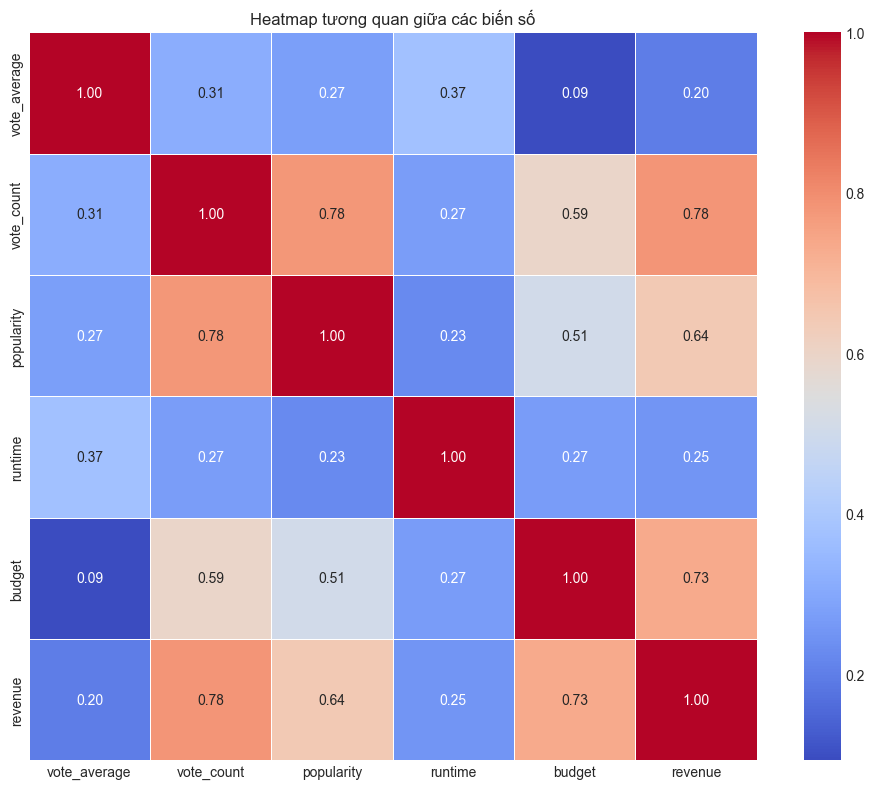

In [27]:
### 3.4. Heatmap tương quan giữa các biến số

corr_cols = ['vote_average', 'vote_count', 'popularity', 'runtime', 'budget', 'revenue']
corr_data = movies_merged[corr_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_data, annot=True, fmt='.2f', cmap='coolwarm', square=True, linewidths=0.5)
plt.title('Heatmap tương quan giữa các biến số')
plt.tight_layout()
plt.show()


## 4. Xây dựng hệ gợi ý phim (Content-Based Filtering)


In [28]:
### 4.1. Chuẩn bị features cho mô hình

# Hàm parse keywords
def extract_keywords(keywords_str):
    try:
        keywords_list = json.loads(keywords_str)
        return ' '.join([k['name'] for k in keywords_list])
    except:
        return ''

# Hàm parse cast (lấy 5 diễn viên đầu tiên)
def extract_cast(cast_str):
    try:
        cast_list = json.loads(cast_str)
        return ' '.join([c['name'].replace(' ', '') for c in cast_list[:5]])
    except:
        return ''

# Hàm parse director từ crew
def extract_director(crew_str):
    try:
        crew_list = json.loads(crew_str)
        for person in crew_list:
            if person.get('job') == 'Director':
                return person['name'].replace(' ', '')
        return ''
    except:
        return ''

movies_merged['keywords_clean'] = movies_merged['keywords'].apply(extract_keywords)
movies_merged['cast_clean'] = movies_merged['cast'].apply(extract_cast)
movies_merged['director_clean'] = movies_merged['crew'].apply(extract_director)
movies_merged['genres_clean'] = movies_merged['genres_list'].apply(lambda x: ' '.join([g.replace(' ', '') for g in x]))

# Kết hợp các features thành một chuỗi duy nhất
movies_merged['combined_features'] = (
    movies_merged['overview'].fillna('') + ' ' +
    movies_merged['genres_clean'] + ' ' +
    movies_merged['keywords_clean'] + ' ' +
    movies_merged['cast_clean'] + ' ' +
    movies_merged['director_clean']
)

print("Sample combined features:")
print(movies_merged[['title', 'combined_features']].head(2))


Sample combined features:
                                      title  \
0                                    Avatar   
1  Pirates of the Caribbean: At World's End   

                                                                                                                                                                                         combined_features  
0  In the 22nd century, a paraplegic Marine is dispatched to the moon Pandora on a unique mission, but becomes torn between following orders and protecting an alien civilization. Action Adventure Fan...  
1  Captain Barbossa, long believed to be dead, has come back to life and is headed to the edge of the Earth with Will Turner and Elizabeth Swann. But nothing is quite as it seems. Adventure Fantasy A...  


In [29]:
### 4.2. Vector hóa với TF-IDF và tính Cosine Similarity

# Khởi tạo TF-IDF Vectorizer
tfidf = TfidfVectorizer(
    max_features=5000,
    stop_words='english',
    ngram_range=(1, 2)
)

# Fit và transform
tfidf_matrix = tfidf.fit_transform(movies_merged['combined_features'])

print(f"TF-IDF matrix shape: {tfidf_matrix.shape}")

# Tính cosine similarity
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)
print(f"Cosine similarity matrix shape: {cosine_sim.shape}")

# Tạo mapping từ title sang index
indices = pd.Series(movies_merged.index, index=movies_merged['title']).drop_duplicates()

print(f"\\nSố phim trong hệ thống: {len(indices)}")


TF-IDF matrix shape: (4800, 5000)
Cosine similarity matrix shape: (4800, 4800)
\nSố phim trong hệ thống: 4800


In [30]:
### 4.3. Hàm gợi ý phim

def get_recommendations(title, top_n=10):
    """
    Trả về top N phim tương tự với phim có title đã cho
    """
    try:
        # Lấy index của phim
        idx = indices[title]
        
        # Lấy similarity scores
        sim_scores = list(enumerate(cosine_sim[idx]))
        
        # Sắp xếp theo similarity (giảm dần)
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
        
        # Lấy top N phim (bỏ phim đầu tiên vì chính nó)
        sim_scores = sim_scores[1:top_n+1]
        
        # Lấy indices của phim
        movie_indices = [i[0] for i in sim_scores]
        
        # Trả về thông tin phim
        result = movies_merged.iloc[movie_indices][['title', 'vote_average', 'vote_count', 'genres_clean', 'overview']]
        result['similarity_score'] = [score[1] for score in sim_scores]
        
        return result
    except KeyError:
        return f"Phim '{title}' không tồn tại trong cơ sở dữ liệu."

# Test hàm gợi ý
print("=== Gợi ý phim tương tự 'Avatar' ===")
recommendations = get_recommendations('Avatar', top_n=5)
print(recommendations[['title', 'similarity_score', 'vote_average']].to_string(index=False))


=== Gợi ý phim tương tự 'Avatar' ===
         title  similarity_score  vote_average
        Aliens          0.357202           7.7
        Alien³          0.349650           6.2
     Moonraker          0.342399           5.9
Silent Running          0.322229           6.3
         Alien          0.315315           7.9


## 5. Đánh giá mô hình


In [39]:
### 5.1. Đánh giá RMSE và MAE

# Với content-based filtering, ta đánh giá bằng cách:
# - Dự đoán rating của phim gợi ý = trung bình có trọng số theo similarity
# - So sánh với rating thực tế

def predict_rating(title, top_n=10):
    """Dự đoán rating cho phim dựa trên các phim tương tự"""
    try:
        idx = indices[title]
        sim_scores = list(enumerate(cosine_sim[idx]))
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:top_n+1]
        
        # Tính rating dự đoán = weighted average
        total_sim = sum([score[1] for score in sim_scores])
        if total_sim == 0:
            return movies_merged.iloc[idx]['vote_average']
        
        weighted_rating = sum([
            movies_merged.iloc[score[0]]['vote_average'] * score[1] 
            for score in sim_scores
        ]) / total_sim
        
        return weighted_rating
    except:
        return None

# Lấy sample để đánh giá (100 phim có vote_count > 100)
sample_movies = movies_merged[movies_merged['vote_count'] > 100].sample(min(3100, len(movies_merged)), random_state=42)

y_true = []
y_pred = []

for title in sample_movies['title']:
    true_rating = sample_movies[sample_movies['title'] == title]['vote_average'].values[0]
    pred_rating = predict_rating(title, top_n=10)
    
    if pred_rating is not None:
        y_true.append(true_rating)
        y_pred.append(pred_rating)

# Tính RMSE và MAE
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)

print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"\\nSố phim đánh giá: {len(y_true)}")


Root Mean Squared Error (RMSE): 0.8794
Mean Absolute Error (MAE): 0.6974
\nSố phim đánh giá: 3100


In [19]:
### 5.2. Đánh giá Precision@K và Recall@K

# Giả định: Phim được coi là "relevant" nếu có rating >= threshold và cùng thể loại
def evaluate_precision_recall(test_movies, K=10, rating_threshold=7.0):
    """
    Đánh giá Precision@K và Recall@K
    - Relevant items: phim có rating >= threshold và chia sẻ ít nhất 1 thể loại với phim gốc
    """
    precisions = []
    recalls = []
    
    for title in test_movies['title']:
        movie_info = movies_merged[movies_merged['title'] == title].iloc[0]
        movie_genres = set(movie_info['genres_list'])
        
        # Lấy recommendations
        recs = get_recommendations(title, top_n=K)
        
        if isinstance(recs, str):  # Trường hợp không tìm thấy
            continue
        
        # Tìm relevant items trong toàn bộ dataset
        relevant_items = movies_merged[
            (movies_merged['vote_average'] >= rating_threshold) &
            (movies_merged['title'] != title) &
            (movies_merged['genres_list'].apply(lambda x: len(set(x) & movie_genres) > 0))
        ]['title'].tolist()
        
        if len(relevant_items) == 0:
            continue
        
        # Tính số recommended items là relevant
        recommended_titles = recs['title'].tolist()
        relevant_recommended = set(recommended_titles) & set(relevant_items)
        
        # Precision@K = (relevant items in top K) / K
        precision = len(relevant_recommended) / K
        
        # Recall@K = (relevant items in top K) / (total relevant items)
        recall = len(relevant_recommended) / len(relevant_items) if len(relevant_items) > 0 else 0
        
        precisions.append(precision)
        recalls.append(recall)
    
    return np.mean(precisions), np.mean(recalls)

# Đánh giá trên sample
test_sample = movies_merged[movies_merged['vote_count'] > 50].sample(min(2500, len(movies_merged)), random_state=42)
precision_at_10, recall_at_10 = evaluate_precision_recall(test_sample, K=10, rating_threshold=7.0)

print(f"Precision@10: {precision_at_10:.4f}")
print(f"Recall@10: {recall_at_10:.4f}")
print(f"\\nSố phim test: {len(test_sample)}")
print(f"Ngưỡng rating cho relevant items: 7.0")


Precision@10: 0.1548
Recall@10: 0.0037
\nSố phim test: 2500
Ngưỡng rating cho relevant items: 7.0


In [15]:
### 5.3. Tóm tắt kết quả đánh giá

print("=" * 60)
print("TỔNG KẾT KẾT QUẢ ĐÁNH GIÁ MÔ HÌNH")
print("=" * 60)
print(f"✓ Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"✓ Mean Absolute Error (MAE): {mae:.4f}")
print(f"✓ Precision@10: {precision_at_10:.4f}")
print(f"✓ Recall@10: {recall_at_10:.4f}")
print("=" * 60)
print(f"\\nMô hình content-based filtering đã được xây dựng thành công!")
print(f"Dataset: {len(movies_merged)} phim từ TMDB 5000")
print(f"Features: overview, genres, keywords, cast, director")
print(f"Vectorization: TF-IDF (max_features=5000, ngram_range=(1,2))")


TỔNG KẾT KẾT QUẢ ĐÁNH GIÁ MÔ HÌNH
✓ Root Mean Squared Error (RMSE): 0.9833
✓ Mean Absolute Error (MAE): 0.8019
✓ Precision@10: 0.1500
✓ Recall@10: 0.0036
\nMô hình content-based filtering đã được xây dựng thành công!
Dataset: 4800 phim từ TMDB 5000
Features: overview, genres, keywords, cast, director
Vectorization: TF-IDF (max_features=5000, ngram_range=(1,2))


In [16]:
## 6. Lưu model và dữ liệu để triển khai

import pickle

# Lưu các object cần thiết
data_to_save = {
    'movies_data': movies_merged[['id', 'title', 'vote_average', 'vote_count', 'popularity', 
                                   'genres_clean', 'overview', 'release_date', 'runtime']],
    'cosine_sim': cosine_sim,
    'indices': indices
}

with open('movie_recommender_model.pkl', 'wb') as f:
    pickle.dump(data_to_save, f)

print("✓ Đã lưu model và dữ liệu vào file 'movie_recommender_model.pkl'")
print(f"✓ Kích thước file: {os.path.getsize('movie_recommender_model.pkl') / (1024*1024):.2f} MB")


✓ Đã lưu model và dữ liệu vào file 'movie_recommender_model.pkl'
✓ Kích thước file: 177.73 MB


## 7. Hướng dẫn sử dụng Web App

Để chạy giao diện web Streamlit:

1. **Đảm bảo đã chạy tất cả cell ở trên** để tạo file `movie_recommender_model.pkl`

2. **Mở terminal/command prompt** và chạy lệnh:
   ```
   streamlit run app.py
   ```

3. **Trình duyệt sẽ tự động mở** tại `http://localhost:8501`

4. **Sử dụng app**:
   - Chọn phim yêu thích từ dropdown
   - Điều chỉnh số lượng gợi ý
   - Nhấn nút "Tìm phim tương tự"
   - Xem kết quả và download CSV nếu cần

---

### 🎉 Hoàn thành!

Project đã bao gồm:
- ✅ Notebook phân tích đầy đủ (`tmdb_recommender.ipynb`)
- ✅ Web App với Streamlit (`app.py`)
- ✅ Requirements file (`requirements.txt`)
- ✅ Hướng dẫn chi tiết (`README.md`)
- ✅ Model đã lưu (`movie_recommender_model.pkl`)

Chúc bạn hoàn thành tốt Final Project! 🚀
